In [375]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import plotly.express as px
from matplotlib import pyplot as plt
import os
from tqdm import tqdm_notebook
sns.set(style = "darkgrid")
%matplotlib inline

In [376]:
dataset_path = os.getcwd() + '/logistic_data/train.csv'
test_dataset_path = os.getcwd() + '/logistic_data/test.csv'

cont_attributes = ['fnlwgt', 'capital_loss', 'education_num', 'hours_per_week', 'age', 'capital_gain']

attributes = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
              'marital_status', 'occupation', 'relationship', 'race', 'sex', 
              'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'price']

In [377]:
data = pd.read_csv(dataset_path, sep=',', header=None, names=attributes)
test_data = pd.read_csv(test_dataset_path, sep=',', header=None, names=attributes)
# data.head()

In [378]:
data.replace({'price': {' <=50K': -1, ' >50K': 1}}, inplace=True)
test_data.replace({'price': {' <=50K.': -1, ' >50K.': 1}}, inplace=True)
test_data['price'].value_counts()

-1    11360
 1     3700
Name: price, dtype: int64

In [379]:
data = pd.concat([pd.get_dummies(data[['workclass', 'education', 'marital_status', 'occupation',
                                      'relationship', 'race', 'sex', 'native_country']],
                                 prefix=['workclass', 'education', 'marital_status', 'occupation',
                                      'relationship', 'race', 'sex', 'native_country']), data], axis=1)
data.drop(columns=['workclass', 'education', 'marital_status', 'occupation',
                   'relationship', 'race', 'sex', 'native_country'], inplace=True)

test_data = pd.concat([pd.get_dummies(test_data[['workclass', 'education', 'marital_status', 'occupation',
                                      'relationship', 'race', 'sex', 'native_country']],
                                 prefix=['workclass', 'education', 'marital_status', 'occupation',
                                      'relationship', 'race', 'sex', 'native_country']), test_data], axis=1)
test_data.drop(columns=['workclass', 'education', 'marital_status', 'occupation',
                   'relationship', 'race', 'sex', 'native_country'], inplace=True)

In [380]:
(set(data.columns.values) - set(test_data.columns.values)) # 

{'native_country_ Holand-Netherlands'}

In [381]:
np.where(data.columns.values == 'native_country_ Holand-Netherlands')

(array([71]),)

In [382]:
test_data.insert(71, 'native_country_ Holand-Netherlands', np.zeros(test_data.shape[0]))

In [383]:
def shuffle(X):
    return X.sample(frac=1, axis=0, random_state=4)
    

In [384]:
data = shuffle(data)
data.reset_index(drop=True, inplace=True)
data.head()

,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,...,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,price
0,0,0,1,0,0,0,0,0,1,0,...,1,0,0,33,280111,7,0,0,38,-1
1,0,0,1,0,0,0,0,0,0,0,...,1,0,0,32,205152,9,3103,0,40,1
2,0,1,0,0,0,0,0,0,0,0,...,1,0,0,28,214881,9,0,0,40,-1
3,0,0,1,0,0,0,0,0,0,0,...,1,0,0,31,48189,9,0,0,45,-1
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,26,198163,14,0,0,40,-1


In [385]:
# Stratified split
nr = round(data.shape[0]*0.8)
minus_one_per = data['price'].value_counts().values[0]/data.shape[0]
plus_one_per = data['price'].value_counts().values[1]/data.shape[0]
train_part1 = data[data['price']==-1].sample(n = round(minus_one_per*nr).astype(int), axis=0, random_state=4)

In [386]:
data.drop(index=train_part1.index, inplace=True)
train_part2 = data[data['price']==1].sample(n = round(plus_one_per*nr).astype(int), axis=0, random_state=4)
data.drop(index=train_part2.index, inplace=True) # remaining data is validation set
training_data = pd.concat([train_part1, train_part2], axis=0)

training_data = shuffle(training_data)
data = shuffle(data)
test_data = shuffle(test_data)

In [387]:
tdata = training_data.iloc[:, :-1]

statdf = tdata.iloc[:, :-1].describe()
low_var_features = list(np.where(statdf.iloc[2,:].values<=0.1)[0])
print('No. of Features with very low variance: ', len(low_var_features))

#checking if all these 48 features are from categorical features or not. Don't want to remove any continuous feature
# without normalizing data first.
print('No. of continous features with very low variance :', 
      len(set(tdata.iloc[:,low_var_features].columns.values) & set(cont_attributes)))

#safely delete those feaures
selected_feat = set(tdata.columns.values) - set(tdata.iloc[:,low_var_features].columns.values)
train_x = tdata.loc[:, list(selected_feat)]
test_x = test_data.loc[:, list(selected_feat)]
valid_x = data.loc[:, list(selected_feat)]

No. of Features with very low variance:  48
No. of continous features with very low variance : 0


In [388]:
training_data = training_data.to_numpy()
data = data.to_numpy()
test_data = test_data.to_numpy()

train_x = train_x.to_numpy()
valid_x = valid_x.to_numpy()
test_x = test_x.to_numpy()

In [389]:
X_train = training_data[:, :-1]
y_train = training_data[:, -1]

X_valid = data[:, :-1]
y_valid = data[:, -1]

# train_valid_set = np.vstack((training_data, data))

In [390]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(24130, 104) (6032, 104) (15060, 104)
(24130,) (6032,) (15060,)


In [391]:
print(train_x.shape, test_x.shape, valid_x.shape)

(24130, 56) (15060, 56) (6032, 56)


### Logistic Regression

In [392]:
def gradient_descent(X, y, coeff, eta, niter): # theta_i
    """
        eta: step size
        X: training set
        y: given predicted values for X
        loss: MSE
        return: coeff
    """
    n_iteration = 0
    
    while n_iteration < niter:
        
        gz = -1*predict(-1*np.dot(X, coeff)*y) 
        g_theta = gz*y                 
        gradient = np.zeros(coeff.shape[0]) # theta_0 included
        
        for i in range(0, coeff.shape[0]): # theta_i
            gradient[i] = np.dot(g_theta, X[:, i])
            
        coeff = coeff - (1/X.shape[0])*eta*gradient
        
#         print('Iteration', n_iteration,' : ', loss(X, y, coeff)) 
        n_iteration = n_iteration + 1
    
    return coeff

In [393]:
def gradient_descent_l1(X, y, coeff, eta, alpha1, niter): # theta_i
    """
        eta: step size
        X: training set
        alpha: inverse regularization strength 
        y: given predicted values for X
        loss: MSE
        return: coeff
    """
    n_iteration = 0
    
    while n_iteration < niter:
        
        gz = -1*predict(-1*np.dot(X, coeff)*y) 
        g_theta = gz*y                 
        gradient = np.zeros(coeff.shape[0]) # theta_0 included
        
        for i in range(0, coeff.shape[0]): # theta_i
            gradient[i] = np.dot(g_theta, X[:, i]) + alpha1*np.sign(coeff[i])
            
        coeff = coeff - (1/X.shape[0])*eta*gradient
        
#         print('Iteration', n_iteration,' : ', loss_l1(X, y, coeff, alpha)) 
        n_iteration = n_iteration + 1
    
    return coeff

In [394]:
def gradient_descent_l2(X, y, coeff, eta, alpha2, niter): # theta_i
    """
        eta: step size
        X: training set
        y: given predicted values for X
        alpha: regularization strength 
        loss: MSE
        return: coeff
    """
    n_iteration = 0
    
    while n_iteration < niter:
        
        gz = -1*predict(-1*np.dot(X, coeff)*y) 
        g_theta = gz*y                 
        gradient = np.zeros(coeff.shape[0]) # theta_0 included
        
        for i in range(0, coeff.shape[0]): # theta_i
            gradient[i] = np.dot(g_theta, X[:, i]) + 2*alpha2*coeff[i]   # L2 Regularized
            
        coeff = coeff - (1/X.shape[0])*eta*gradient
        
#         print('Iteration', n_iteration,' : ', loss_l2(X, y, coeff, alpha)) 
        n_iteration = n_iteration + 1
    
    return coeff

In [395]:
def zscore_normalization(X, nu, std):
    """
        X: data 2d array
        nu: 1d mean vector
        std: 1d std vector
    """
    X = (X - nu)/std
    return X

In [396]:
def loss(X, y, coeff): # loss function : logistic loss
    """
        X: training set 2-d array
        y: given values for X 1-d array {-1, +1}
        returns : total loss of all the samples
        beware of np.power instead use np.exp
    """
    conf = -1*np.dot(X, coeff)*y
    log_loss = np.log(1 + np.exp(conf))
    return np.sum(log_loss)

In [397]:
def loss_l1(X, y, coeff, alpha): # loss function : logistic loss
    """
        X: training set 2-d array
        y: given values for X 1-d array {-1, +1}
        returns : total loss of all the samples
        beware of np.power instead use np.exp
    """
    conf = -1*np.dot(X, coeff)*y
    log_loss = np.log(1 + np.exp(conf))
    return np.sum(log_loss) + alpha*np.sum(np.abs(coeff))

In [398]:
def loss_l2(X, y, coeff, alpha): # loss function : logistic loss
    """
        X: training set 2-d array
        y: given values for X 1-d array {-1, +1}
        returns : total loss of all the samples
        beware of np.power instead use np.exp
    """
    conf = -1*np.dot(X, coeff)*y
    log_loss = np.log(1 + np.exp(conf))
    return np.sum(log_loss) + alpha*np.sum(np.power(coeff, 2))

In [399]:
def predict(z): # H_theta(x) 
    """
        x: Data point 1-d array
        coeff: 1-d array
        returns: prediction for all data points 1-d array
    """
    return 1/(1 + np.exp(-z)) # 1/(1 + e^-z)

In [400]:
def accuracy(w_theta, X, y_true):
    y_pred = np.dot(X, w_theta)
    y_pred[y_pred > 0] = 1
    y_pred[y_pred < 0] = -1    

    return np.sum(y_pred == y_true)/X.shape[0]

In [401]:
def showerror(result): # Plot generalization error
    result = pd.DataFrame(result, columns=['#samples', 'training_error', 'validation_error'])
    result['training_error'] = 1 - result['training_error']
    result['validation_error'] = 1 - result['validation_error']
    matplotlib.rc('figure', figsize=(10, 5))
    ax = sns.lineplot(x='#samples', y='training_error', data=result, label='training_error', color='b')
    sns.lineplot(x='#samples', y='validation_error', data=result, color='r', label='validation_error', ax=ax)
    ax.set_title('Error vs No. of training samples')
    ax.legend()
    ax.set_ylabel('Error')
    return

In [402]:
def LogisticRegression(X_train, y_train, X_valid, y_valid, X_test, y_test, eta, alpha1, alpha2, niter, reg):
        
    global graph
    
    n = X_train.shape[1] + 1 # LR Coefficients
    coeff = np.zeros(n)
    result = np.zeros((1000, 3)) # no. of samples, training error, validation error
    
    acc_l1 = np.zeros((niter)) 
    acc_l2 = np.zeros((niter)) 
    
    # normalization using zscore before adding offset
    current_mean = np.mean(X_train, axis=0)
    current_std = np.std(X_train, axis=0)
    
    X_train = zscore_normalization(X_train, current_mean, current_std)
    X_valid = zscore_normalization(X_valid, current_mean, current_std)  # using same mean, std of training set
    X_test = zscore_normalization(X_test, current_mean, current_std) 
    
    # bias = 1 in the training set and validation set - 1*theta_0
    X_train = np.hstack((np.ones(X_train.shape[0])[:, np.newaxis], X_train))
    X_valid = np.hstack((np.ones(X_valid.shape[0])[:, np.newaxis], X_valid))
    X_test = np.hstack((np.ones(X_test.shape[0])[:, np.newaxis], X_test))
    
      # checking generalization error  
#     for i in tqdm_notebook(range(1, 1001)):
#         w_theta = gradient_descent(X_train[:i, :], y_train[:i], coeff, eta, niter)
#         result[i-1, :] = np.array([i, accuracy(w_theta, X_train[:i, :], y_train[:i]), accuracy(w_theta, X_valid, y_valid)])
    
#     showerror(result)    
    
    w_theta = gradient_descent(X_train, y_train, coeff, eta, niter)
    

    if(reg == 'l2'):
        w_theta2 = gradient_descent_l2(X_train, y_train, coeff, eta, alpha2, niter)

        print('alpha2', alpha2, ' L2 (Train, Validation, Test) : ',
                                                 accuracy(w_theta2, X_train, y_train), 
                                                 accuracy(w_theta2, X_valid, y_valid),
                                                 accuracy(w_theta2, X_test, y_test))
        
        if(graph):
            for j in range(0, niter):
                # train on current training set
                theta_l2 = gradient_descent_l1(X_train, y_train, coeff, eta, alpha2, j)
                acc_l2[j] = accuracy(theta_l2, X_test, y_test)

            return acc_l2
    
    elif(reg == 'l1'):
        w_theta1 = gradient_descent_l1(X_train, y_train, coeff, eta, alpha1, niter)
        print('alpha1', alpha1, ' L1  (Train, Validation, Test) : ',
                                                 accuracy(w_theta1, X_train, y_train), 
                                                 accuracy(w_theta1, X_valid, y_valid),
                                                 accuracy(w_theta1, X_test, y_test))
        
        if(graph):
            for j in range(0, niter):
                # train on current training set
                theta_l1 = gradient_descent_l1(X_train, y_train, coeff, eta, alpha1, j)
                acc_l1[j] = accuracy(theta_l1, X_test, y_test)

            return acc_l1
    
    elif(reg == 'none'):
        print('Without regularization (Train, Validation, Test) : ',
                                                 accuracy(w_theta, X_train, y_train), 
                                                 accuracy(w_theta, X_valid, y_valid),
                                                 accuracy(w_theta, X_test, y_test))
    
    return 
    

In [403]:
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

eta = 0.9
alpha2_list = [0.0001, 0.1, 0.9, 1, 12, 50] #best one is 12
niter = 100

graph = False
for alpha2 in alpha2_list:
    LogisticRegression(X_train, y_train, X_valid, y_valid, X_test, y_test, eta, 0, alpha2, niter, 'l2') # On validation

alpha2 0.0001  L2 (Train, Validation, Test) :  0.8477414007459594 0.8506299734748011 0.845551128818061
alpha2 0.1  L2 (Train, Validation, Test) :  0.8477828429341069 0.8506299734748011 0.845551128818061
alpha2 0.9  L2 (Train, Validation, Test) :  0.8476585163696643 0.8507957559681698 0.845551128818061
alpha2 1  L2 (Train, Validation, Test) :  0.8476585163696643 0.8507957559681698 0.845551128818061
alpha2 12  L2 (Train, Validation, Test) :  0.8479486116866971 0.8509615384615384 0.845551128818061
alpha2 50  L2 (Train, Validation, Test) :  0.8471612101118939 0.8504641909814323 0.8453519256308101


In [405]:
print('With Reduced features')
print('-'*20)
for alpha2 in alpha2_list:
    LogisticRegression(train_x, y_train, valid_x, y_valid, test_x, y_test, eta, 0, alpha2, niter, 'l2') # On validation

With Reduced features
--------------------
alpha2 0.0001  L2 (Train, Validation, Test) :  0.8463738085370908 0.8514588859416445 0.8454183266932271
alpha2 0.1  L2 (Train, Validation, Test) :  0.8463738085370908 0.8514588859416445 0.8454183266932271
alpha2 0.9  L2 (Train, Validation, Test) :  0.8464566929133859 0.8514588859416445 0.8453519256308101
alpha2 1  L2 (Train, Validation, Test) :  0.8464566929133859 0.8514588859416445 0.8453519256308101
alpha2 12  L2 (Train, Validation, Test) :  0.8465395772896809 0.8516246684350133 0.845551128818061
alpha2 50  L2 (Train, Validation, Test) :  0.8457107335267302 0.8512931034482759 0.8453519256308101


In [406]:
eta = 0.9
alpha1_list = [0.0001, 0.001, 0.1, 0.8, 1, 2, 10] # best one is 0.8
niter = 100

for alpha1 in alpha1_list:
    LogisticRegression(X_train, y_train, X_valid, y_valid, X_test, y_test, eta, alpha1, 0, niter, 'l1') # On validation

alpha1 0.0001  L1  (Train, Validation, Test) :  0.8477414007459594 0.8506299734748011 0.845551128818061
alpha1 0.001  L1  (Train, Validation, Test) :  0.8477414007459594 0.8506299734748011 0.845551128818061
alpha1 0.1  L1  (Train, Validation, Test) :  0.8477414007459594 0.8506299734748011 0.845551128818061
alpha1 0.8  L1  (Train, Validation, Test) :  0.8478242851222545 0.8511273209549072 0.845551128818061
alpha1 1  L1  (Train, Validation, Test) :  0.8478242851222545 0.8509615384615384 0.8456839309428951
alpha1 2  L1  (Train, Validation, Test) :  0.8479486116866971 0.8507957559681698 0.8460823373173971
alpha1 10  L1  (Train, Validation, Test) :  0.847865727310402 0.8504641909814323 0.8468127490039841


In [407]:
print('With Reduced features')
print('-'*20)
for alpha1 in alpha1_list:
    LogisticRegression(train_x, y_train, valid_x, y_valid, test_x, y_test, eta, alpha1, 0, niter, 'l1') # On validation

With Reduced features
--------------------
alpha1 0.0001  L1  (Train, Validation, Test) :  0.8463738085370908 0.8514588859416445 0.8454183266932271
alpha1 0.001  L1  (Train, Validation, Test) :  0.8463738085370908 0.8514588859416445 0.8454183266932271
alpha1 0.1  L1  (Train, Validation, Test) :  0.8463738085370908 0.8516246684350133 0.8454847277556441
alpha1 0.8  L1  (Train, Validation, Test) :  0.8463323663489433 0.8514588859416445 0.845551128818061
alpha1 1  L1  (Train, Validation, Test) :  0.8464152507252383 0.8514588859416445 0.845551128818061
alpha1 2  L1  (Train, Validation, Test) :  0.8463323663489433 0.8514588859416445 0.8456839309428951
alpha1 10  L1  (Train, Validation, Test) :  0.8463323663489433 0.8511273209549072 0.8469455511288181


In [201]:
eta = 0.9
niter = 100
LogisticRegression(X_train, y_train, X_valid, y_valid, X_test, y_test, eta, 0, 0, niter, 'none') # On validation

Without regularization (Train, Validation, Test) :  0.8477414007459594 0.8506299734748011 0.845551128818061


In [207]:
graph = True
acc_pts_l2 = LogisticRegression(X_train, y_train, X_valid, y_valid, X_test, y_test, eta, 0, 12, niter, 'l2') # On validation

alpha2 12  L2 (Train, Validation, Test) :  0.8479486116866971 0.8509615384615384 0.845551128818061


In [220]:
graph = True
acc_pts_l1 = LogisticRegression(X_train, y_train, X_valid, y_valid, X_test, y_test, eta, 0.8, 0, niter, 'l1') # On validation

alpha1 0.8  L1  (Train, Validation, Test) :  0.8478242851222545 0.8511273209549072 0.845551128818061


In [221]:
test_acc_l2 = np.hstack((np.arange(niter)[:, np.newaxis]+1, acc_pts_l2[:, np.newaxis]))
test_acc_l2 = pd.DataFrame(test_acc_l2, columns=['iteration_number', 'accuracy'])

test_acc_l1 = np.hstack((np.arange(niter)[:, np.newaxis]+1, acc_pts_l1[:, np.newaxis]))
test_acc_l1 = pd.DataFrame(test_acc_l1, columns=['iteration_number', 'accuracy'])

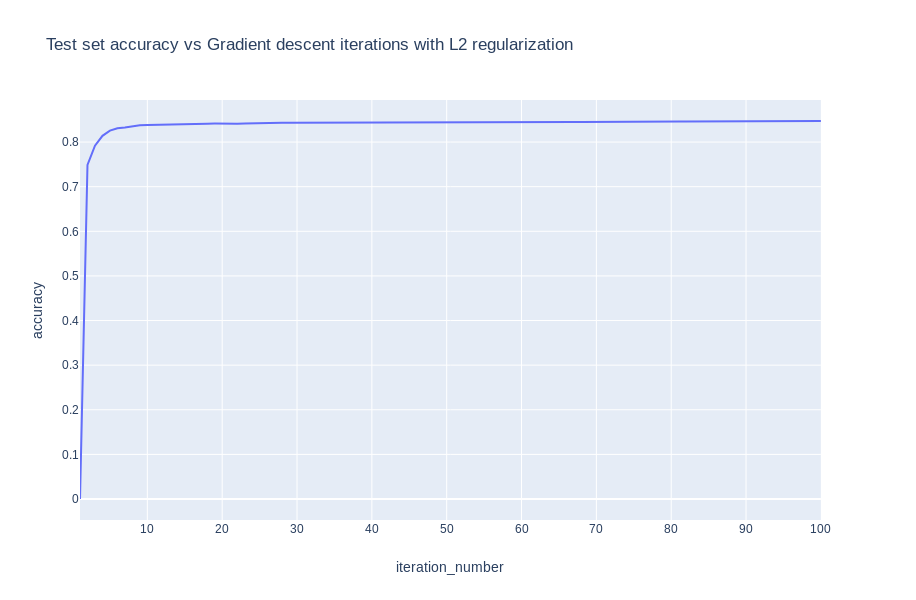

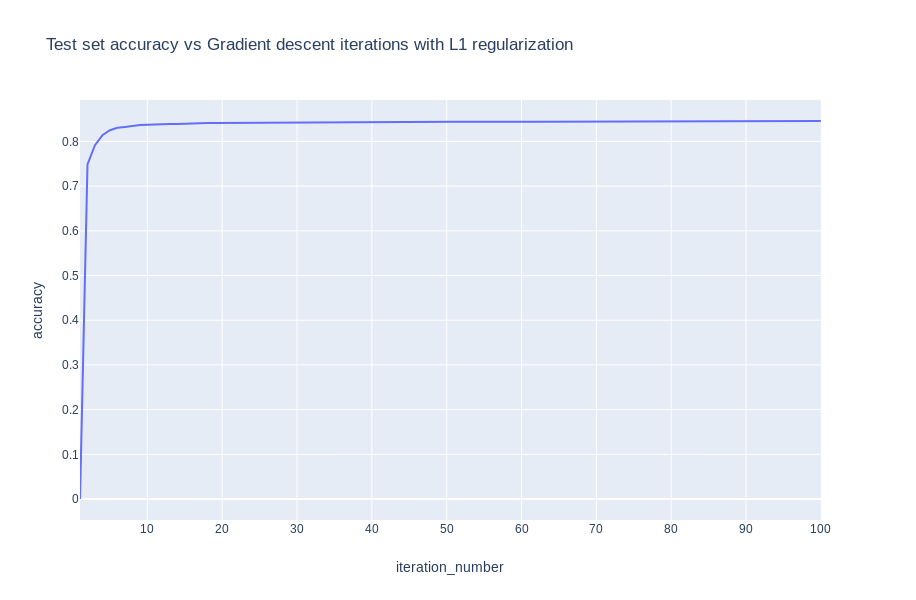

In [222]:
fig = px.line(test_acc_l2, x='iteration_number', y='accuracy', hover_name='accuracy', 
              hover_data=['accuracy', 'iteration_number'],
              title='Test set accuracy vs Gradient descent iterations with L2 regularization')

fig.show()

fig = px.line(test_acc_l1, x='iteration_number', y='accuracy', hover_name='accuracy', 
              hover_data=['accuracy', 'iteration_number'],
              title='Test set accuracy vs Gradient descent iterations with L1 regularization')
fig.show()

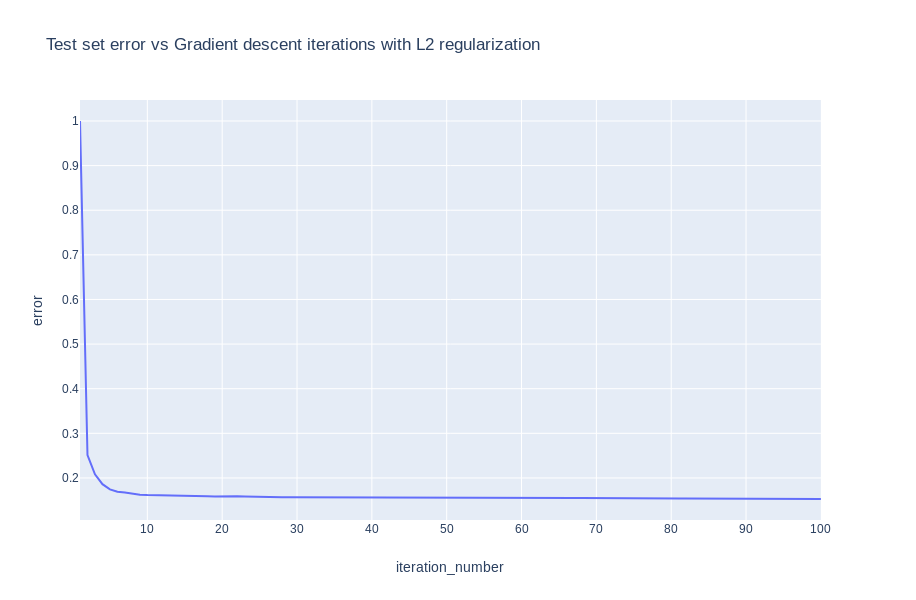

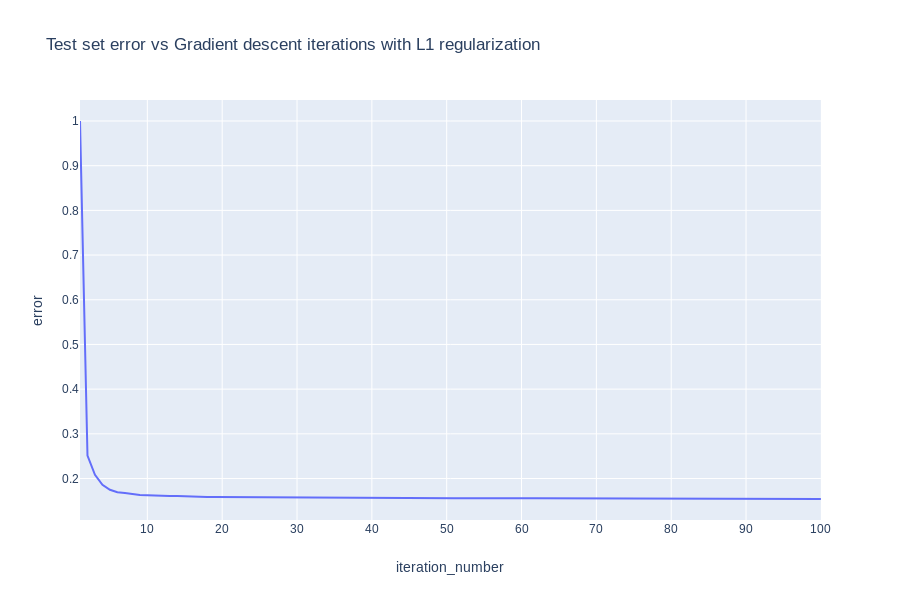

In [223]:
test_error_l2 = pd.DataFrame(columns=['iteration_number', 'error']) 
test_error_l2['error'] = 1-test_acc_l2['accuracy']
test_error_l2['iteration_number'] = np.arange(niter) + 1

test_error_l1 = pd.DataFrame(columns=['iteration_number', 'error']) 
test_error_l1['error'] = 1-test_acc_l1['accuracy']
test_error_l1['iteration_number'] = np.arange(niter) + 1

fig = px.line(test_error_l2, x='iteration_number', y='error', hover_name='error', 
              hover_data=['error', 'iteration_number'],
              title='Test set error vs Gradient descent iterations with L2 regularization')

fig.show()

fig = px.line(test_error_l1, x='iteration_number', y='error', hover_name='error', 
              hover_data=['error', 'iteration_number'],
              title='Test set error vs Gradient descent iterations with L1 regularization')
fig.show()